In [1]:
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec

/home/wcks13589/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
data = pd.read_csv('./data/sample_zip_if_cca_cdtx0001_hist.csv').sort_values(by=['csmdt'])

In [3]:
idx_map = np.load('./data/sample_idx_map.npy', allow_pickle=True).item()

In [4]:
data = data[data.csmdt < '2019-01-01']

In [5]:
data

,bnsfg,bnspt,chid,csmdt,iterm,mcc,objam,scity,tcode,hcefg
0,N,0,++OwUlLSxwS6YnHcDeLacA==,2018-01-01,0,5411,151,TAOYUAN,5,NaN
5025,N,0,dZsmhKhBUKkTsTTMREiUOw==,2018-01-01,0,5411,6651,TAICHUNG,5,NaN
5024,N,0,dZsmhKhBUKkTsTTMREiUOw==,2018-01-01,0,5309,22100,TAOYUAN CITY,5,NaN
5023,N,0,dZGKpSJ06HQn1XP6lkN8hw==,2018-01-01,0,5812,4269,TAIPEI,5,NaN
5022,N,0,dZGKpSJ06HQn1XP6lkN8hw==,2018-01-01,0,5311,2356,TAIPEI,5,NaN
...,...,...,...,...,...,...,...,...,...,...
2779259,N,0,JiJSWYYgaVvtzuNSGaShPg==,2018-12-31,0,5399,7176,TAIPEI,5,NaN
2779260,N,0,Jien5gG13Tgo6l7wXeRotQ==,2018-12-31,0,4112,8143,TAITUNG,5,NaN
2779263,N,0,JjvR0jPqSwfPUTd9JlwHFA==,2018-12-31,0,5541,5580,YUNLIN,5,NaN
2779262,N,0,JjqLTtNr5B/eihVF4VKFyQ==,2018-12-31,0,5811,3250,CHIAYI,5,NaN


In [6]:
l = len(idx_map)
for i, j  in tqdm(enumerate(set(data.mcc))):
    idx_map[j] = i+l

In [7]:
pairs = data.iloc[:,[2,5]].drop_duplicates()
edges_unordered = pairs.to_numpy()
edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                 dtype=np.int32).reshape(edges_unordered.shape)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(len(idx_map), len(idx_map)),
                    dtype=np.float32)
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [8]:
edges.shape

(518928, 2)

In [9]:
new_edges = []
for i in edges:
    new_edges.append(np.array([i[1],i[0]]))
edges = np.append(edges, np.array(new_edges), axis = 0)

In [10]:
edges.shape

(1037856, 2)

In [11]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(torch.Tensor(edges.T).long(), embedding_dim=64, walk_length=2,
                 context_size=2, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

In [12]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [ ]:
model.eval()
z = model(torch.arange(adj.shape[0], device=device))
z = TSNE(n_components=2).fit_transform(z.detach().cpu().numpy())
colors = ['#065535', '#bada55']

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(z[:50000, 0], z[:50000, 1], s=20, color=colors[0])
plt.scatter(z[50000:, 0], z[50000:, 1], s=20, color=colors[1])

In [13]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [18]:
import time
start = time.time()

for epoch in range(1, 102):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
print(time.time()-start)

Epoch: 01, Loss: 0.7519
Epoch: 02, Loss: 0.7504
Epoch: 03, Loss: 0.7507
Epoch: 04, Loss: 0.7492
Epoch: 05, Loss: 0.7484
Epoch: 06, Loss: 0.7482
Epoch: 07, Loss: 0.7495
Epoch: 08, Loss: 0.7473
Epoch: 09, Loss: 0.7488
Epoch: 10, Loss: 0.7469
Epoch: 11, Loss: 0.7462
Epoch: 12, Loss: 0.7468
Epoch: 13, Loss: 0.7444
Epoch: 14, Loss: 0.7440
Epoch: 15, Loss: 0.7433
Epoch: 16, Loss: 0.7431
Epoch: 17, Loss: 0.7422
Epoch: 18, Loss: 0.7412
Epoch: 19, Loss: 0.7412
Epoch: 20, Loss: 0.7417
Epoch: 21, Loss: 0.7403
Epoch: 22, Loss: 0.7416
Epoch: 23, Loss: 0.7404
Epoch: 24, Loss: 0.7395
Epoch: 25, Loss: 0.7390
Epoch: 26, Loss: 0.7383
Epoch: 27, Loss: 0.7389
Epoch: 28, Loss: 0.7384
Epoch: 29, Loss: 0.7379
Epoch: 30, Loss: 0.7363
Epoch: 31, Loss: 0.7368
Epoch: 32, Loss: 0.7365
Epoch: 33, Loss: 0.7358
Epoch: 34, Loss: 0.7363
Epoch: 35, Loss: 0.7346
Epoch: 36, Loss: 0.7354
Epoch: 37, Loss: 0.7362
Epoch: 38, Loss: 0.7349
Epoch: 39, Loss: 0.7336
Epoch: 40, Loss: 0.7355
Epoch: 41, Loss: 0.7351
Epoch: 42, Loss:

In [19]:
model.eval()
z = model(torch.arange(adj.shape[0], device=device))
#z = TSNE(n_components=2).fit_transform(z.detach().cpu().numpy())

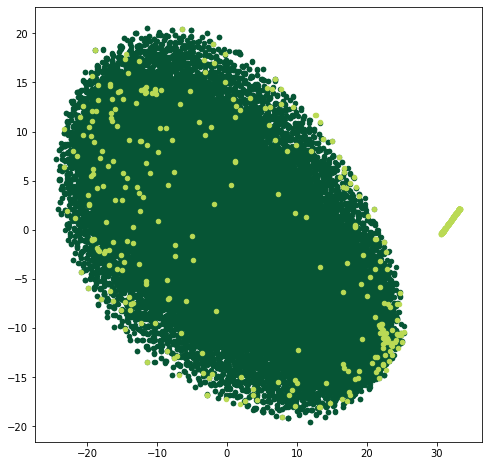

In [27]:
colors = ['#065535', '#bada55']
plt.figure(figsize=(8, 8))
plt.scatter(z[:50000, 0], z[:50000, 1], s=20, color=colors[0])
plt.scatter(z[50000:, 0], z[50000:, 1], s=20, color=colors[1])

In [20]:
np.save('node2vec_0112.npz',z.detach().cpu().numpy())

In [25]:
np.save('sample_cust_mcc_idx_map', idx_map)